In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import joblib

plt.style.use("seaborn-v0_8")

PATH = "TransFiles_3rzk6/ci_data_eda_prepared.csv"
df = pd.read_csv(PATH, parse_dates=["Date"])
s = df.groupby("Date")["NetAmount"].sum().sort_index()
print(f"len={len(s)}, period={s.index.min().date()}→{s.index.max().date()}")

len=118, period=2023-01-01→2024-01-01


In [2]:
df_pairs = df.copy()
df_pairs["Inflow"] = (df_pairs["Deposit"] > 0) & df_pairs["Category"].isin(["Misc", "Transport"])
df_pairs["Outflow"] = (df_pairs["Withdrawal"] > 0) & df_pairs["Category"].isin(["Misc", "Transport"])

inflows = df_pairs[df_pairs["Inflow"]][["Date", "Deposit"]].rename(columns={"Deposit": "Amt"})
outflows = df_pairs[df_pairs["Outflow"]][["Date", "Withdrawal"]].rename(columns={"Withdrawal": "Amt"})

tol = 1e-2
pairs = inflows.merge(outflows, on=["Date", "Amt"], how="inner")
pair_dates = set(pairs["Date"])

df["InternalTransfer"] = (
    df["Category"].isin(["Misc", "Transport"]) &
    (
        (df["Deposit"] > 0) & df["Date"].isin(pair_dates) |
        (df["Withdrawal"] > 0) & df["Date"].isin(pair_dates)
    )
)

print("Найдено внутренних переводов:", df["InternalTransfer"].sum())

s_no_transfers = (
    df[~df["InternalTransfer"]]
    .groupby("Date")["NetAmount"]
    .sum()
    .sort_index()
)
print(f"len без переводов: {len(s_no_transfers)}, период: {s_no_transfers.index.min().date()}→{s_no_transfers.index.max().date()}")
s = s_no_transfers

Найдено внутренних переводов: 37
len без переводов: 113, период: 2023-01-01→2024-01-01


prev mean/std: -764.5239393939394 1773.2589330818926
last14 mean/std: -27.42714285714289 5900.777747211905

prev quantiles:
 0.05   -6230.283
0.25    -746.500
0.50    -326.000
0.75    -129.000
0.95     709.450
Name: NetAmount, dtype: float64

last14 quantiles:
 0.05   -5565.3385
0.25    -180.0000
0.50     -75.0000
0.75       1.2500
0.95    5848.6500
Name: NetAmount, dtype: float64

count |z|>2: 2
Date
2023-10-07    0.277926
2023-10-09    0.950523
2023-10-10    0.379259
2023-10-11    0.386026
2023-10-12    0.391665
2023-12-01    0.420426
2023-12-02    0.318354
2023-12-03    0.406891
2023-12-06    0.481895
2023-12-07    8.890142
2023-12-09   -8.054930
2023-12-11    0.172132
2023-12-12    0.363469
2024-01-01    0.435652
Name: NetAmount, dtype: float64
baseline std: 1775.250034749141 threshold: 4438.125086872852
first exceed: 2023-12-09 00:00:00 prev_break: 2023-12-07 00:00:00
last 10 roll std:
 Date
2023-10-12     356.494821
2023-12-01     357.270421
2023-12-02     342.529748
2023-12-03  

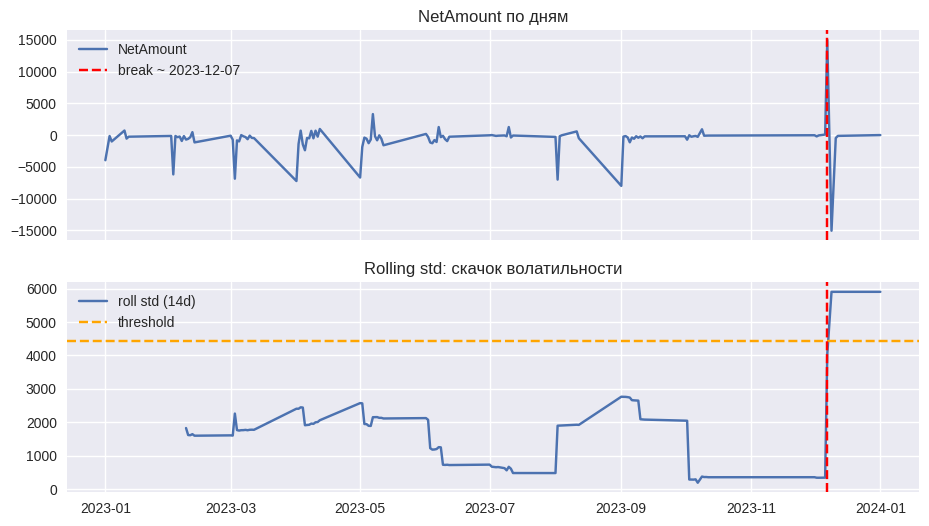

In [3]:
last14 = s.tail(14); prev = s.iloc[:-14]
print("prev mean/std:", prev.mean(), prev.std())
print("last14 mean/std:", last14.mean(), last14.std())
print("\nprev quantiles:\n", prev.quantile([0.05,0.25,0.5,0.75,0.95]))
print("\nlast14 quantiles:\n", last14.quantile([0.05,0.25,0.5,0.75,0.95]))
z = (last14 - prev.mean())/(prev.std()+1e-9)
print("\ncount |z|>2:", (z.abs()>2).sum())
print(z)

roll_mean = s.rolling(14).mean()
roll_std = s.rolling(14).std()
t = int(len(s)*0.7)
baseline = roll_std.iloc[:t].median()
threshold = baseline*2.5
exceed = roll_std[roll_std > threshold]
first_break = exceed.index.min() if not exceed.empty else None
if first_break:
    pos = s.index.get_loc(first_break)
    prev_break = s.index[pos-1] if pos>0 else s.index[0]
else:
    prev_break = None

print("baseline std:", baseline, "threshold:", threshold)
print("first exceed:", first_break, "prev_break:", prev_break)
print("last 10 roll std:\n", roll_std.tail(10))

fig, axes = plt.subplots(2,1, figsize=(11,6), sharex=True)
axes[0].plot(s.index, s, label="NetAmount")
if prev_break: axes[0].axvline(prev_break, color="red", linestyle="--", label=f"break ~ {prev_break.date()}")
axes[0].legend(); axes[0].set_title("NetAmount по дням")
axes[1].plot(roll_std.index, roll_std, label="roll std (14d)")
axes[1].axhline(threshold, color="orange", linestyle="--", label="threshold")
if prev_break: axes[1].axvline(prev_break, color="red", linestyle="--")
axes[1].legend(); axes[1].set_title("Rolling std: скачок волатильности")
plt.show()

In [4]:
def mae(a, b): return float(np.mean(np.abs(a-b)))

def naive_forecast(series, horizon):
    return np.repeat(series.iloc[-1], horizon)

def seasonal_naive(series, horizon, season=7):
    last_season = series.iloc[-season:]
    reps = int(np.ceil(horizon/season))
    return np.tile(last_season, reps)[:horizon]

horizon = 14
naive_pred = naive_forecast(s, horizon)
snaive_pred = seasonal_naive(s, horizon, season=7)

if len(s) >= horizon:
    truth = s.tail(horizon).values
    print("Naive MAE (last 14 vs truth):", mae(naive_pred, truth))
    print("Seasonal-naive MAE:", mae(snaive_pred, truth))
else:
    print("Недостаточно точек для бенчмарков.")

Naive MAE (last 14 vs truth): 2319.2842857142855
Seasonal-naive MAE: 2272.712857142857


In [5]:
def prepare_series(raw, clip_pct=0.0, drop_last=0, diff=False):
    series = raw.copy()
    if clip_pct > 0:
        lo, hi = np.quantile(series, [clip_pct, 1-clip_pct])
        series = np.clip(series, lo, hi)
    if diff:
        series = series.diff().dropna()
    if drop_last > 0:
        if drop_last >= len(series): raise ValueError("drop_last too big")
        series = series[:-drop_last]
    return series

clip_pct = 0.01 
drop_last = 14
diff_flag = False
series_prep = prepare_series(s, clip_pct=clip_pct, drop_last=drop_last, diff=diff_flag)
print("prepared len:", len(series_prep))

prepared len: 99


In [6]:
class WindowDataset(Dataset):
    def __init__(self, series, window, horizon, target_idx):
        self.series = series.astype(np.float32)
        self.window = window
        self.horizon = horizon
        self.target_idx = target_idx
    def __len__(self): return len(self.target_idx)
    def __getitem__(self, i):
        t = self.target_idx[i]
        x = self.series[t-self.window:t]
        y = self.series[t+self.horizon-1]
        return torch.tensor(x).unsqueeze(-1), torch.tensor(y)

class PosEnc(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).float().unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:,:x.size(1)]

class TSTransformer(nn.Module):
    def __init__(self, d_model=96, nhead=4, num_layers=2, ff=128, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=ff, dropout=dropout,
                                               batch_first=True)
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.pos = PosEnc(d_model)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.inp(x)
        x = self.pos(x)
        x = self.enc(x)
        return self.head(x[:,-1,:]).squeeze(-1)

def make_loaders(series, window, horizon, val_size, test_size, batch_size):
    n = len(series)
    train_idx = np.arange(0, n - val_size - test_size)
    val_idx   = np.arange(n - val_size - test_size, n - test_size)
    test_idx  = np.arange(n - test_size, n)
    min_t, max_t = window, n - horizon
    def filt(idx): return idx[(idx >= min_t) & (idx < max_t)]
    train_ds = WindowDataset(series, window, horizon, filt(train_idx))
    val_ds   = WindowDataset(series, window, horizon, filt(val_idx))
    test_ds  = WindowDataset(series, window, horizon, filt(test_idx))
    make = lambda ds, sh: DataLoader(ds, batch_size=batch_size, shuffle=sh, drop_last=False)
    return make(train_ds, True), make(val_ds, False), make(test_ds, False)

def eval_mae(model, loader, device, mean, std):
    model.eval(); tot=0; cnt=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            pred_un = pred*std + mean
            yb_un = yb*std + mean
            mae = (pred_un - yb_un).abs().mean()
            tot += mae.item()*len(xb); cnt += len(xb)
    return tot / max(cnt, 1)

In [7]:
def train_one(series, window=21, horizon=14, val_size=20, test_size=20,
              d_model=96, num_layers=2, dropout=0.1, lr=1e-3, weight_decay=1e-4,
              epochs=200, batch_size=16, patience=20, device=None):
    train_end = len(series) - val_size - test_size
    if train_end <= window: raise ValueError("not enough data")
    mean = float(series[:train_end].mean())
    std = float(series[:train_end].std(ddof=0)) or 1.0
    scaled = (series - mean) / std
    train_dl, val_dl, test_dl = make_loaders(scaled, window, horizon, val_size, test_size, batch_size)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = TSTransformer(d_model=d_model, nhead=4, num_layers=num_layers, ff=128, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.L1Loss()
    best = float("inf"); best_state=None; patience_left=patience
    for _ in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
        val = eval_mae(model, val_dl, device, mean=0, std=1)
        if val < best - 1e-6:
            best = val; best_state = {k:v.cpu() for k,v in model.state_dict().items()}; patience_left = patience
        else:
            patience_left -= 1
        if patience_left == 0: break
    if best_state: model.load_state_dict(best_state)
    train_mae = eval_mae(model, train_dl, device, mean, std)
    val_mae   = eval_mae(model, val_dl, device, mean, std)
    test_mae  = eval_mae(model, test_dl, device, mean, std)
    return model, (train_mae, val_mae, test_mae), (mean, std), scaled

model, metrics, (mean, std), scaled = train_one(
    series=series_prep.values,
    window=21,
    horizon=14,
    val_size=20,
    test_size=20,
    d_model=96,
    num_layers=2,
    dropout=0.2,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=200,
    batch_size=16,
    patience=20,
)
print("MAE train/val/test:", metrics)

/home/dark/.local/share/mamba/envs/notebook/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


MAE train/val/test: (755.5429944490131, 1034.829931640625, 446.9434509277344)


In [8]:
def recursive_forecast(model, scaled_series, mean, std, window, horizon, device):
    hist = scaled_series.tolist(); out=[]
    model.eval()
    with torch.no_grad():
        for _ in range(horizon):
            x = torch.tensor(hist[-window:], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(-1)
            yhat = model(x).item()
            out.append(yhat); hist.append(yhat)
    out = np.array(out)
    return out*std + mean

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
forecast = recursive_forecast(model, scaled, mean, std, window=21, horizon=14, device=device)
dates = pd.date_range(start=series_prep.index[-1] + pd.Timedelta(days=1), periods=14, freq="D")
forecast_df = pd.DataFrame({"Date": dates, "Forecast": forecast})
print(forecast_df.head())

Path("outputs").mkdir(exist_ok=True, parents=True)
joblib.dump({"state_dict": model.state_dict(), "mean": mean, "std": std, "window": 21}, "outputs/netamount_transformer_final.pkl")
forecast_df.to_csv("outputs/netamount_transformer_forecast_final.csv", index=False)

        Date    Forecast
0 2023-10-07 -471.635609
1 2023-10-08 -507.280405
2 2023-10-09 -524.525288
3 2023-10-10 -526.138710
4 2023-10-11 -476.878662


In [9]:
artifact = joblib.load("outputs/netamount_transformer_final.pkl")
state_dict = artifact["state_dict"]; mean = artifact["mean"]; std = artifact["std"]; window = artifact["window"]

loaded_model = TSTransformer(d_model=96, nhead=4, num_layers=2, ff=128, dropout=0.2)
loaded_model.load_state_dict(state_dict)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)
loaded_model.eval()

def predict_series(model, series: pd.Series, mean, std, window, horizon, device):
    series_np = series.values.astype(np.float32)
    scaled = (series_np - mean) / (std or 1.0)
    return recursive_forecast(model, scaled, mean, std, window=window, horizon=horizon, device=device)

pred = predict_series(loaded_model, series_prep, mean, std, window=window, horizon=14, device=device)
pred_df = pd.DataFrame({"Date": pd.date_range(series_prep.index[-1]+pd.Timedelta(days=1), periods=14, freq="D"),
                        "Forecast": pred})
print(pred_df.head())

        Date    Forecast
0 2023-10-07 -471.635717
1 2023-10-08 -507.280405
2 2023-10-09 -524.525451
3 2023-10-10 -526.138656
4 2023-10-11 -476.878662


In [10]:
series = s.copy()
k = 2
extremes = series.abs().nlargest(k).index
series_wo_ext = series.drop(extremes)
print("Удалены точки:", extremes)

Удалены точки: DatetimeIndex(['2023-12-09', '2023-12-07'], dtype='datetime64[ns]', name='Date', freq=None)


In [11]:
roll_std = series_wo_ext.rolling(14).std()
baseline = roll_std.iloc[: int(len(series_wo_ext)*0.7)].median()
threshold = baseline*2.5
exceed = roll_std[roll_std > threshold]
print("first exceed after trimming:", exceed.index.min() if not exceed.empty else None)

first exceed after trimming: None


In [12]:
clip_pct = 0.01
lo, hi = series.quantile([clip_pct, 1-clip_pct])
series_clip = series.clip(lo, hi)

z = (series - series.mean())/(series.std()+1e-9)
series_ztrim = series[(z.abs() <= 3)]  # оставить |z|<=3

In [13]:
roll_std = series_wo_ext.rolling(14).std()
baseline = roll_std.iloc[: int(len(series_wo_ext)*0.7)].median()
threshold = baseline*2.5
exceed = roll_std[roll_std > threshold]
print("first exceed after trimming:", exceed.index.min() if not exceed.empty else None)

first exceed after trimming: None


До очистки: 113 После: 107
Удалено точек: 6
first exceed after cleaning: None


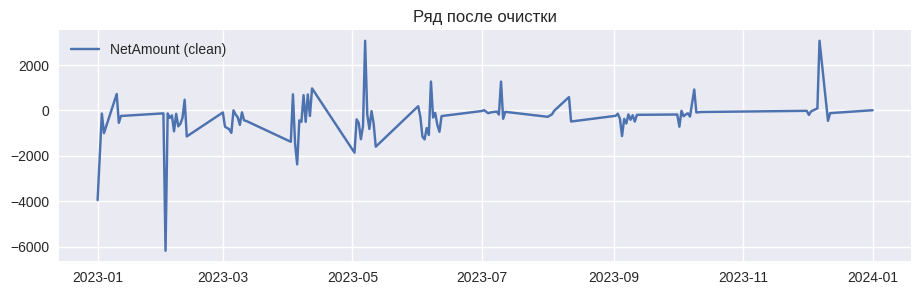

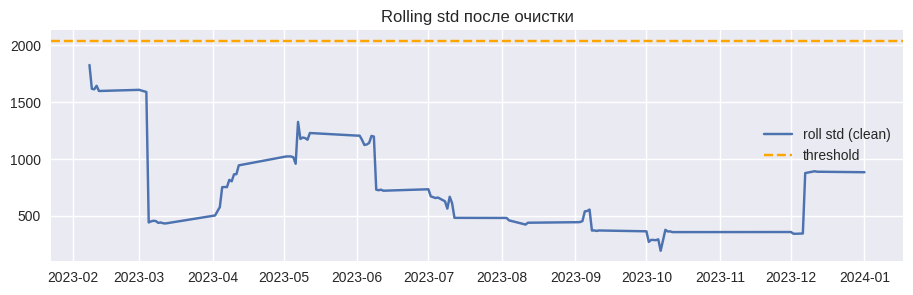

In [14]:
series_raw = s.copy()

# 1) Клип по перцентилям
clip_pct = 0.01
lo, hi = series_raw.quantile([clip_pct, 1-clip_pct])
series_clip = series_raw.clip(lo, hi)

# 2) Z-trim
z = (series_clip - series_clip.mean()) / (series_clip.std(ddof=0) + 1e-9)
series_clean = series_clip[z.abs() <= 3]

print("До очистки:", len(series_raw), "После:", len(series_clean))
print("Удалено точек:", len(series_raw) - len(series_clean))

roll_std_clean = series_clean.rolling(14).std()
t = int(len(series_clean) * 0.7)
baseline = roll_std_clean.iloc[:t].median()
threshold = baseline * 2.5
exceed = roll_std_clean[roll_std_clean > threshold]
print("first exceed after cleaning:", exceed.index.min() if not exceed.empty else None)

plt.figure(figsize=(11,3))
plt.plot(series_clean.index, series_clean, label="NetAmount (clean)")
plt.title("Ряд после очистки")
plt.legend(); plt.show()

plt.figure(figsize=(11,3))
plt.plot(roll_std_clean.index, roll_std_clean, label="roll std (clean)")
plt.axhline(threshold, color="orange", linestyle="--", label="threshold")
if not exceed.empty:
    plt.axvline(exceed.index.min(), color="red", linestyle="--", label="exceed")
plt.legend(); plt.title("Rolling std после очистки")
plt.show()

series_prep = series_clean

In [15]:
model, metrics, (mean, std), scaled = train_one(
    series=series_prep.values,
    window=21,
    horizon=14,
    val_size=20,
    test_size=20,
    d_model=96,
    num_layers=2,
    dropout=0.2,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=200,
    batch_size=16,
    patience=20,
)
print("MAE train/val/test:", metrics)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
forecast = recursive_forecast(model, scaled, mean, std, window=21, horizon=14, device=device)
dates = pd.date_range(start=series_prep.index[-1] + pd.Timedelta(days=1), periods=14, freq="D")
forecast_df = pd.DataFrame({"Date": dates, "Forecast": forecast})
print(forecast_df.head())

Path("outputs").mkdir(exist_ok=True, parents=True)
joblib.dump({"state_dict": model.state_dict(), "mean": mean, "std": std, "window": 21}, "outputs/netamount_transformer_clean.pkl")
forecast_df.to_csv("outputs/netamount_forecast_clean.csv", index=False)

MAE train/val/test: (478.9773241126019, 306.431689453125, 858.44091796875)
        Date    Forecast
0 2024-01-02 -227.294848
1 2024-01-03 -193.695003
2 2024-01-04 -177.508087
3 2024-01-05 -170.445746
4 2024-01-06 -173.544931


Walk-forward MAE (last 60, loaded model): 477.3227487440619


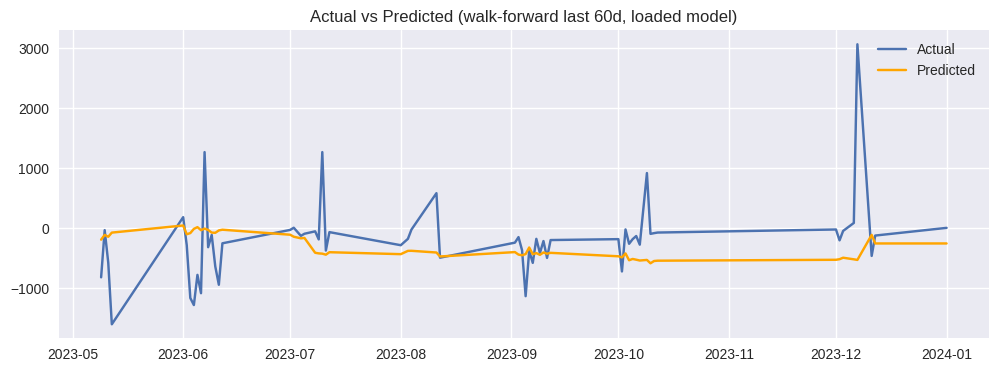

In [16]:
artifact = joblib.load("outputs/netamount_transformer_clean.pkl")
state_dict = artifact["state_dict"]
mean = artifact["mean"]
std = artifact["std"]
window = artifact["window"]

loaded_model = TSTransformer(d_model=96, nhead=4, num_layers=2, ff=128, dropout=0.2)
loaded_model.load_state_dict(state_dict)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)
loaded_model.eval()

def walk_forward_with_loaded(series: pd.Series, model, mean, std, window, n_eval=60):
    series_np = series.values.astype(np.float32)
    preds, trues, dates = [], [], []
    for t in range(len(series_np) - n_eval, len(series_np)):
        hist = series_np[:t]
        if len(hist) <= window:
            continue
        hist_scaled = (hist - mean) / (std or 1.0)
        x = torch.tensor(hist_scaled[-window:], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(-1)
        with torch.no_grad():
            yhat = model(x).item()
        yhat_un = yhat * std + mean
        preds.append(yhat_un)
        trues.append(series_np[t])
        dates.append(series.index[t])
    return pd.Series(trues, index=dates), pd.Series(preds, index=dates)

truth, pred = walk_forward_with_loaded(series_prep, loaded_model, mean, std, window, n_eval=60)
mae_wf = float(np.mean(np.abs(truth - pred)))
print("Walk-forward MAE (last 60, loaded model):", mae_wf)

plt.figure(figsize=(12,4))
plt.plot(truth.index, truth.values, label="Actual")
plt.plot(pred.index, pred.values, label="Predicted", color="orange")
plt.title("Actual vs Predicted (walk-forward last 60d, loaded model)")
plt.legend()
plt.show()